#  <font color='green'>       **Malaria Bounding Boxes**       </font>

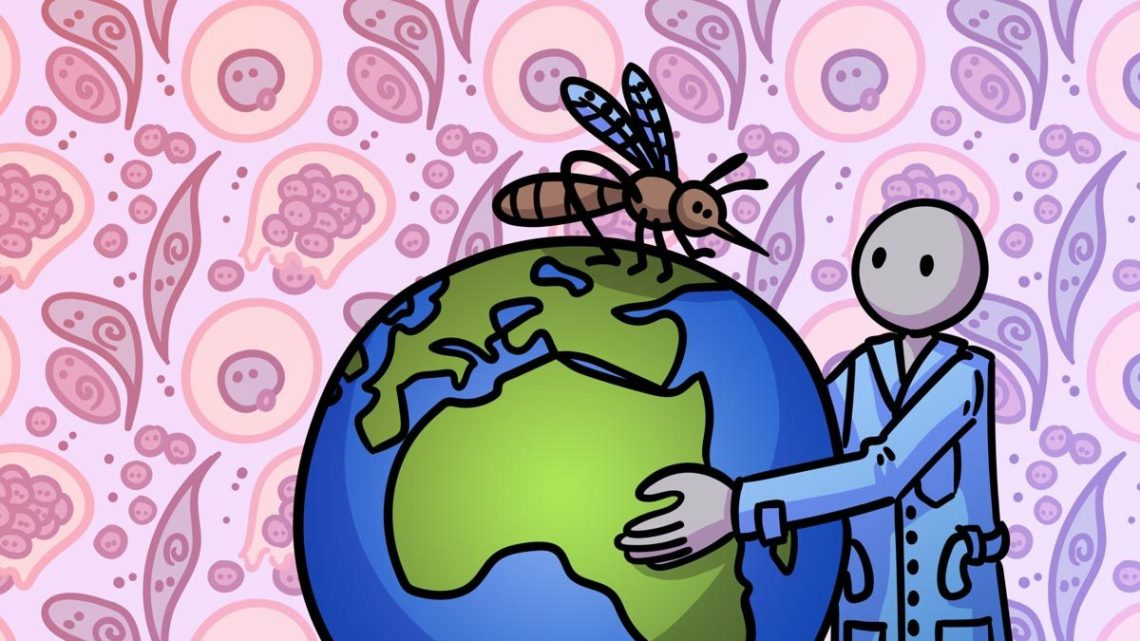

In [0]:
from IPython.display import display, Image
display(Image(filename='malaria.jpg'))

# **Business/Real world problem**-

**Problem Statement-**

Malaria is a disease caused by Plasmodium parasites that remains a major threat in global health, affecting 200 million people and causing 400,000 deaths a year. The main species of malaria that affect humans are Plasmodium falciparum and Plasmodium vivax. For malaria as well as other microbial infections, manual inspection of thick and thin blood smears by trained microscopists remains the gold standard for parasite detection and stage determination because of its low reagent and instrument cost and high flexibility. Despite manual inspection being extremely low throughput and susceptible to human bias, automatic counting software remains largely unused because of the wide range of variations in brightfield microscopy images. However, a robust automatic counting and cell classification solution would provide enormous benefits due to faster and more accurate quantitative results without human variability; researchers and medical professionals could better characterize stage-specific drug targets and better quantify patient reactions to drugs.

The data consists of two classes of uninfected cells (RBCs and leukocytes) and four classes of infected cells (gametocytes, rings, trophozoites, and schizonts).Annotators were permitted to mark some cells as difficult if not clearly in one of the cell classes.

# **Source/Useful links-**

The Dataset can be downloaded from-

1-Data Source: https://www.kaggle.com/kmader/malaria-bounding-boxes


# **Real world/Business objectives and constraints-**

1-No low-latency requirement.

2-Interpretability is important. 

3-Errors can be costly.

4-Probability of a cell belonging to each class is needed.

# **Machine Learning Problem-**

**Data overview-**

We are given folder named malaria which contains 3 files-

1-**Images** -contains train and test images

2-**Test json**- it contains test image name and its bounding box information in json format.

3-**Training json**-it contains train image name and its bounding box information in json format.

# **Mapping the real world problem to machine learning problem-**

**Type of problem-**

Given an image of blood sample, we need to mask the cell and label to which class(infected vs uninfected) it belongs (applying mask-rcnn).
 
**Performance Metric-**

**mAP(mean average precision)-**
The average or mean of the average precision (AP) across all of the images in a dataset is called the mean average precision, or mAP.

**Losses-**

rpn_class_loss : How well the Region Proposal Network separates background with objects

rpn_bbox_loss : How well the RPN localize objects

mrcnn_bbox_loss : How well the Mask RCNN localize objects

mrcnn_class_loss : How well the Mask RCNN recognize each class of object

mrcnn_mask_loss : How well the Mask RCNN segment objects

total_loss=sum of all the losses

so objective is to minimize the total loss

# **Machine learning objectives and constraints-**

1-Probabalities of cell belonging to specific category is needed.

2-no latency constraints as in medical field reports are given within few hours.

3-Interpretability.



**References-**

1-https://github.com/matterport/Mask_RCNN

2-https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

3-https://www.jeremyjordan.me/evaluating-image-segmentation-models/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Loading the Data

In [0]:
"""loading the kaggle json file"""

!pip install -q kaggle

from google.colab import files
files.upload()

In [0]:
'''make directory'''

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
#downloading the dataset

!kaggle datasets download -d kmader/malaria-bounding-boxes

100% 4.19G/4.21G [01:24<00:00, 67.0MB/s]
100% 4.21G/4.21G [01:24<00:00, 53.7MB/s]


In [0]:
#installing the pacakage to unzip the dataset

!pip install pyunpack
from pyunpack import Archive
Archive('malaria-bounding-boxes.zip').extractall('.')

  Created wheel for pyunpack: filename=pyunpack-0.1.2-cp36-none-any.whl size=5162 sha256=5aa48a29fbd71624fa2f09305c5ed6218f17238c41ff2a75301eb89ab51cfab1
  Stored in directory: /root/.cache/pip/wheels/af/44/08/60613970881e542c0baad1f2dea5ed8e6716bc573f49197b7e
Successfully built pyunpack


In [0]:
import shutil
shutil.rmtree("malaria/malaria")

# Test Data's EDA

In [0]:
'''importing the necessary libraries'''

import warnings 
warnings.filterwarnings("ignore")

import seaborn as sns
from numpy import expand_dims
from numpy import mean
import os
import csv
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches
import json
from tqdm import tqdm
import pandas as pd 
import glob
import skimage

In [0]:
"""reading the given test json file"""

test=pd.read_json("malaria/test.json")
test.head()

image                                            objects
0  {'checksum': 'eea3bfd6a929bcb06f9786667cd3fbb2...  [{'bounding_box': {'minimum': {'r': 576, 'c': ...
1  {'checksum': '2d85fc8ffdb875bb569878243437e4f5...  [{'bounding_box': {'minimum': {'r': 1048, 'c':...
2  {'checksum': 'f7c02b6247f3ccfcd4a22c1f06e0c72c...  [{'bounding_box': {'minimum': {'r': 979, 'c': ...
3  {'checksum': '50634ef166ae993b4562b96f315ff6db...  [{'bounding_box': {'minimum': {'r': 402, 'c': ...
4  {'checksum': '74dd777a74e5a4b24aaee574a99e1459...  [{'bounding_box': {'minimum': {'r': 314, 'c': ...

Converting the given test json file into appropriate format

In [0]:
'''reading the test json file'''

test_json = 'malaria/test.json'

with open(test_json) as file:
       file.seek(0)
       test_data = json.load(file)

0 stands for uninfected cells and 1 stands for infected cells
so as to make it contain 2 class 

In [0]:
"""converting the category to numerical label"""

cat_dict = {'red blood cell':0, 'trophozoite': 1, 'schizont': 1, 'difficult':1, 'ring':1, 'leukocyte':0, 'gametocyte': 1}

In [0]:
'''appending the json info to list'''

test_data_=[]

for i in test_data:
  
  path = i['image']['pathname'][8:]
  for j in i['objects']:
    category = j['category']
    bounding_box = j['bounding_box']
    line =path,bounding_box['minimum']['c'],bounding_box['minimum']['r'],bounding_box['maximum']['c'],bounding_box['maximum']['r'],cat_dict[category]
    test_data_.append(line)
  

In [0]:
'''creating the csv file for test data'''

headers = ["image",'x_min', 'y_min', 'x_max','y_max', 'Category']
with open('test.csv', 'w') as f:
        wr = csv.writer(f, quoting=csv.QUOTE_ALL)
        wr.writerow(headers)
        wr.writerows(test_data_)

In [0]:
'''reading the test csv file'''

test_df=pd.read_csv('drive/My Drive/mask2/test.csv')
test_df.tail()

image  x_min  ...  y_max  Category
5917  887cc81a-bae3-4360-a115-23ae05ac3a4f.jpg    694  ...   1145         0
5918  887cc81a-bae3-4360-a115-23ae05ac3a4f.jpg   1381  ...    617         0
5919  887cc81a-bae3-4360-a115-23ae05ac3a4f.jpg   1725  ...   1196         1
5920  887cc81a-bae3-4360-a115-23ae05ac3a4f.jpg    374  ...    653         1
5921  887cc81a-bae3-4360-a115-23ae05ac3a4f.jpg     74  ...    581         1

[5 rows x 6 columns]

In [0]:
#shape of test dataframe
test_df.shape

(5922, 6)

there are 5922 rows & 6 columns.

In [0]:
#checking null values
test_df.isnull().sum()

image       0
x_min       0
y_min       0
x_max       0
y_max       0
Category    0
dtype: int64

No missing data in test df

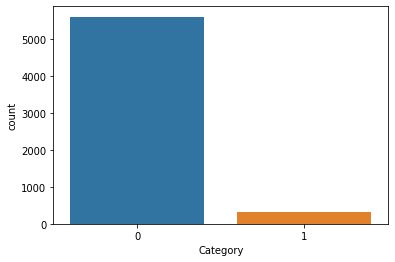

In [0]:
#number of datapoints in each class
sns.countplot(x="Category", data=test_df)

In [0]:
#number of datapoints in each category

test_df['Category'].value_counts()

0    5614
1     308
Name: Category, dtype: int64

The above two cell denotes that it is imbalanced dataset

In [0]:
#storing the name of image in test data

test_img=test_df.image.unique()
print(len(test_img))

120


In [0]:
#making the test_image directory to store test image

!mkdir test_image

In [0]:
#storing the test image in test_image folder

path = "malaria/images/"
moveto = "test_image/"
files = os.listdir(path)
files.sort()
for f in files:
  for i in test_img:
    if f==i:
      src=path+f
      dst=moveto+f
      shutil.move(src,dst)
print("DONE")

DONE


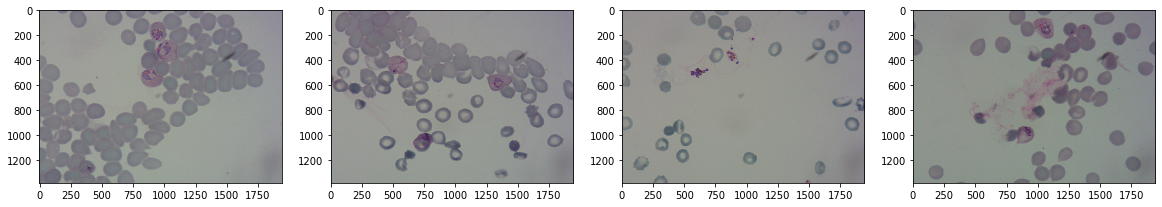

In [0]:
'''showing some of the test image'''

fig = plt.figure(figsize= (20, 20))
cols = 4
rows = 1
test_dir="test_image/"
test_path=os.listdir(test_dir)
for i in range(4):
    filePath = os.path.join(test_dir, random.choice(test_path))
    ax1 = fig.add_subplot(rows, cols, i + 1)
    img = mpimg.imread(filePath)
    plt.imshow(img)
    
plt.show()

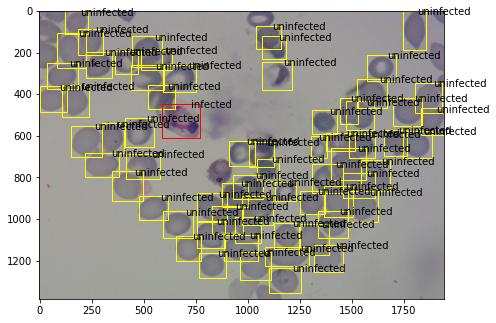

In [0]:
"""showing test image with bounding box"""

#https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image

fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('test_image/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg')
plt.imshow(image)


# iterating over the image for different objects
for _,row in test_df[test_df.image == "41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg"].iterrows():
    xmin = row.x_min
    xmax = row.x_max
    ymin = row.y_min
    ymax = row.y_max
    
    width = xmax - xmin
    height = ymax - ymin
    # assign different color to different classes of objects
    if row.Category == 0:
        edgecolor = 'yellow'
        ax.annotate('uninfected', xy=(xmax-40,ymin+20))
    else:
        edgecolor = 'red'
        ax.annotate('infected', xy=(xmax-40,ymin+20))
    
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

# Train Data's EDA

In [0]:
"""reading the given train json file"""

tr=pd.read_json("malaria/training.json")
tr.head()

image                                            objects
0  {'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...  [{'bounding_box': {'minimum': {'r': 1057, 'c':...
1  {'checksum': '1225a18efce159eddf7b0e80e0ea642c...  [{'bounding_box': {'minimum': {'r': 734, 'c': ...
2  {'checksum': '3eaf840523c30fdf38897ffa01e194eb...  [{'bounding_box': {'minimum': {'r': 724, 'c': ...
3  {'checksum': '8a111dffacfa433029492780b9535091...  [{'bounding_box': {'minimum': {'r': 563, 'c': ...
4  {'checksum': 'ccef403e971460b86444cca669e68ca1...  [{'bounding_box': {'minimum': {'r': 618, 'c': ...

Converting the json file to appropriate format

In [0]:
#reading the train json file

training_json = 'malaria/training.json'

with open(training_json) as file:
       file.seek(0)
       train_data = json.load(file)

In [0]:
'''appending the json info to list'''

train_data_=[]

for i in train_data:
  path = i['image']['pathname'][8:]
  for j in i['objects']:
    category = j['category']
    bounding_box = j['bounding_box']
    line =path,bounding_box['minimum']['c'],bounding_box['minimum']['r'],bounding_box['maximum']['c'],bounding_box['maximum']['r'],cat_dict[category]
    train_data_.append(line)
  

In [0]:
'''creating the csv file for test data'''

headers = ["image",'x_min', 'y_min', 'x_max','y_max', 'Category']
with open('train.csv', 'w') as f:
        wr = csv.writer(f, quoting=csv.QUOTE_ALL)
        wr.writerow(headers)
        wr.writerows(train_data_)

In [0]:
'''reading the test csv file'''

train_df=pd.read_csv('drive/My Drive/mask2/train.csv')
train_df.head()

image  x_min  ...  y_max  Category
0  8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   1440  ...   1158         0
1  8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   1303  ...    971         0
2  8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    900  ...    689         0
3  8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    611  ...    408         0
4  8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    881  ...    312         0

[5 rows x 6 columns]

In [0]:
#checking null values
train_df.isnull().sum()

image       0
x_min       0
y_min       0
x_max       0
y_max       0
Category    0
dtype: int64

In [0]:
#number of rows and col in train
train_df.shape

(80113, 6)

there are 80113 rows and 6 columns in train dataframe

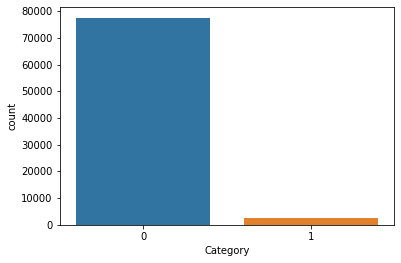

In [0]:
#bar plot showing datapoints in each category

sns.countplot(x="Category", data=train_df)

In [0]:
#number of datapoints in each category
train_df['Category'].value_counts()

0    77523
1     2590
Name: Category, dtype: int64

The above 2 cell shows the train data is also imbalanced.

In [0]:
#storing the name of image in train data

train_img=train_df.image.unique()
print(len(train_img))

1208


In [0]:
#storing the train image in train_image folder

!mkdir train_image
import os, shutil
path = "malaria/images/"
moveto = "train_image/"
files = os.listdir(path)
files.sort()
for f in files:
  for i in train_img:
    if f==i:
      src=path+f
      dst=moveto+f
      shutil.move(src,dst)
print("DONE")

DONE


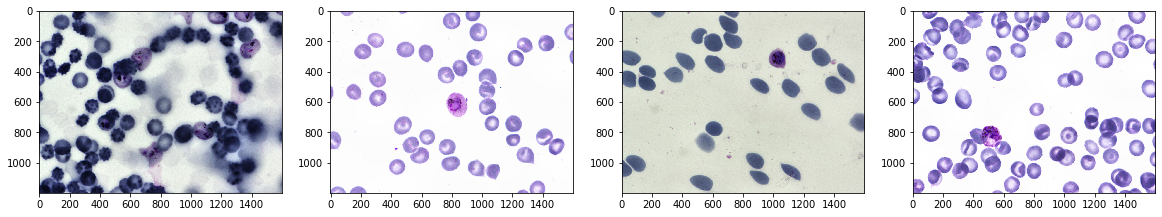

In [0]:
'''showing some of the train image'''

fig = plt.figure(figsize= (20, 20))
cols = 4
rows = 1
train_dir="train_image/"
train_path=os.listdir(train_dir)
for i in range(4):
    filePath = os.path.join(train_dir, random.choice(train_path))
    ax1 = fig.add_subplot(rows, cols, i + 1)
    img = mpimg.imread(filePath)
    plt.imshow(img)
    
plt.show()

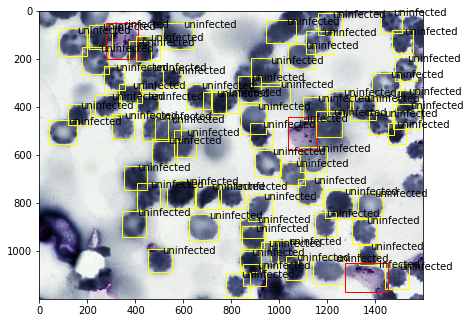

In [0]:
"""showimg test image with bounding box"""

fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('train_image/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png')
plt.imshow(image)


# iterating over the image for different objects
for _,row in train_df[train_df.image == "8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png"].iterrows():
    xmin = row.x_min
    xmax = row.x_max
    ymin = row.y_min
    ymax = row.y_max
    
    width = xmax - xmin
    height = ymax - ymin
    # assign different color to different classes of objects
    if row.Category == 0:
        edgecolor = 'yellow'
        ax.annotate('uninfected', xy=(xmax-40,ymin+20))
   
    else:
        edgecolor = 'red'
        ax.annotate('infected', xy=(xmax-40,ymin+20))
    
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

# MASK_RCNN on Malaria Dataset (training)

In [0]:
'''cloning the matterport mask rcnn '''

!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.84 MiB | 12.62 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [0]:
# Import Mask RCNN libraries and setting root directory

ROOT_DIR = '/content/'

import sys
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.utils import compute_ap
from mrcnn.model import mold_image

Using TensorFlow backend.


In [0]:
#setting the train and test directory

train_dir = os.path.join(ROOT_DIR, 'drive/My Drive/mask2/train_image')
test_dir = os.path.join(ROOT_DIR, 'drive/My Drive/mask2/test_image')

In [0]:
#loading the coco weights

!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

In [0]:
"""function to give the path of each image"""

def get_image_filepath_train(data_dir):
    
    '''
    data_dir=takes the train image directory
    return:name of images in the associated directory
    '''
  
    fps = glob.glob(data_dir+'/'+'*.png')
    return list(set(fps))

In [0]:
"""function which returns the image path and it's related annotations"""

def parse_data_train(data_dir, annotation_file): 
    
    """
    data_dir:train_image directory path
    annotation_file:csv file contaioning bounding box info of the image
    return:image and its associated bounding box annotations
    """
  
  
    image_fps = get_image_filepath_train(data_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in annotation_file.iterrows(): 
        fp = os.path.join(data_dir, row['image'])
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [0]:
"""function to give the path of each image"""

def get_image_filepath_test(data_dir):
    
    '''
    data_dir=takes the train image directory
    return:name of images in the associated directory
    '''
  
    fps = glob.glob(data_dir+'/'+'*.jpg')
    return list(set(fps))

In [0]:
"""function which returns the image path and it's related annotations"""

def parse_data_test(data_dir, annotation_file): 
    
    """
    data_dir:train_image directory path
    annotation_file:csv file contaioning bounding box info of the image
    return:image and its associated bounding box annotations
    """
  
  
    image_fps = get_image_filepath_test(data_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in annotation_file.iterrows(): 
        fp = os.path.join(data_dir, row['image'])
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [0]:
#setting the detector config

class DetectorConfig(Config):
  
    """Configuration for training malaria detection on the malaria dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    
    NAME = 'malaria'
    
    # Train on 1 GPU and 3 images per GPU.
    
    GPU_COUNT = 1
    IMAGES_PER_GPU =3
    
    BACKBONE = 'resnet50'
    
    #background+malaria class
    
    NUM_CLASSES = 1+2
    
    #image min and max dim
    
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    #steps in one epoch
    STEPS_PER_EPOCH = 100
    
    #setting threshold
    DETECTION_MIN_CONFIDENCE=0.5
    
    
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [0]:
#defining the detector dataset
# class that defines and loads the malaria dataset

class DetectorDataset(utils.Dataset):
  
    """
    Dataset class for training malaria cell detection on the malaria bounding box dataset.
    """

    def __init__(self, image_filepath, image_annotations, height, width):
        super().__init__(self)
        
        # Add classes
        self.add_class('malaria', 1, "Uninfected")
        self.add_class('malaria', 2, "Infected")
        
        # add images 
        for i, fp in enumerate(image_filepath):
            annotations = image_annotations[fp]
            self.add_image('malaria', image_id=i, path=fp, annotations=annotations, height=1200, width=1600)
            
    #load image reference       
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
    
    # load and read image from where it is stored
    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = cv2.imread(fp)
        return image
    
    # load the masks for an image
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        mask = np.zeros((info['height'], info['width'], count), dtype=np.uint8)
        class_ids = list()
        for i, a in enumerate(annotations):
            if a['Category'] == 0:
                x_min = int(a['x_min'])
                y_min = int(a['y_min'])
                x_max = int(a['x_max'])
                y_max = int(a['y_max'])
                mask_instance = mask[:, :, i].copy()
                cv2.rectangle(mask_instance, (x_min, y_min), (x_max, y_max),(255,125,255), -1)
                mask[:, :, i] = mask_instance
                class_ids.append(self.class_names.index("Uninfected"))
            
            else:
                x_min=int(a["x_min"])
                y_min=int(a["y_min"])
                x_max=int(a["x_max"])
                y_max=int(a['y_max'])
                mask_instance=mask[:,:,i].copy()
                cv2.rectangle(mask_instance,(x_min,y_min),(x_max,y_max),(125,128,250),-1)
                mask[:,:,i]=mask_instance
                class_ids.append(self.class_names.index("Infected"))    
                    
        return mask,np.array(class_ids)

In [0]:
#getting the image path and its annotations

image_filepath, image_annotations = parse_data_train(train_dir,train_df)

In [0]:
#getting the image path and its annotations

image_filepath_test, image_annotations_test = parse_data_test(test_dir,test_df)

In [0]:
#dividing the train data into train and validation set

image_filepath_list = list(image_filepath)
random.shuffle(image_filepath_list)
val_size = 300
image_filepath_val = image_filepath_list[:val_size]
image_filepath_train = image_filepath_list[val_size:]

print(len(image_filepath_train),len(image_filepath_val))


908 300


In [0]:
# prepare the training dataset

dataset_train = DetectorDataset(image_filepath_train,image_annotations,1200,1600)
dataset_train.prepare()

In [0]:
#prepare the validation dataset

dataset_val = DetectorDataset(image_filepath_val,image_annotations,1200,1600)
dataset_val.prepare()

In [0]:
#prepare the test dataset

dataset_test = DetectorDataset(image_filepath_test,image_annotations_test,1383,1944)
dataset_test.prepare()

In [0]:
#training the custom model

model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching number of classes

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

In [0]:
## train heads with higher lr to speedup the learning

model.train(dataset_train, dataset_val,learning_rate=0.006*2,epochs=20,layers='heads')


Starting at epoch 0. LR=0.012

Checkpoint Path: /content/malaria20200102T1638/mask_rcnn_malaria_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Ti

In [0]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

%tensorboard --logdir /content/drive/My\ Drive/mask2/malaria_cfg

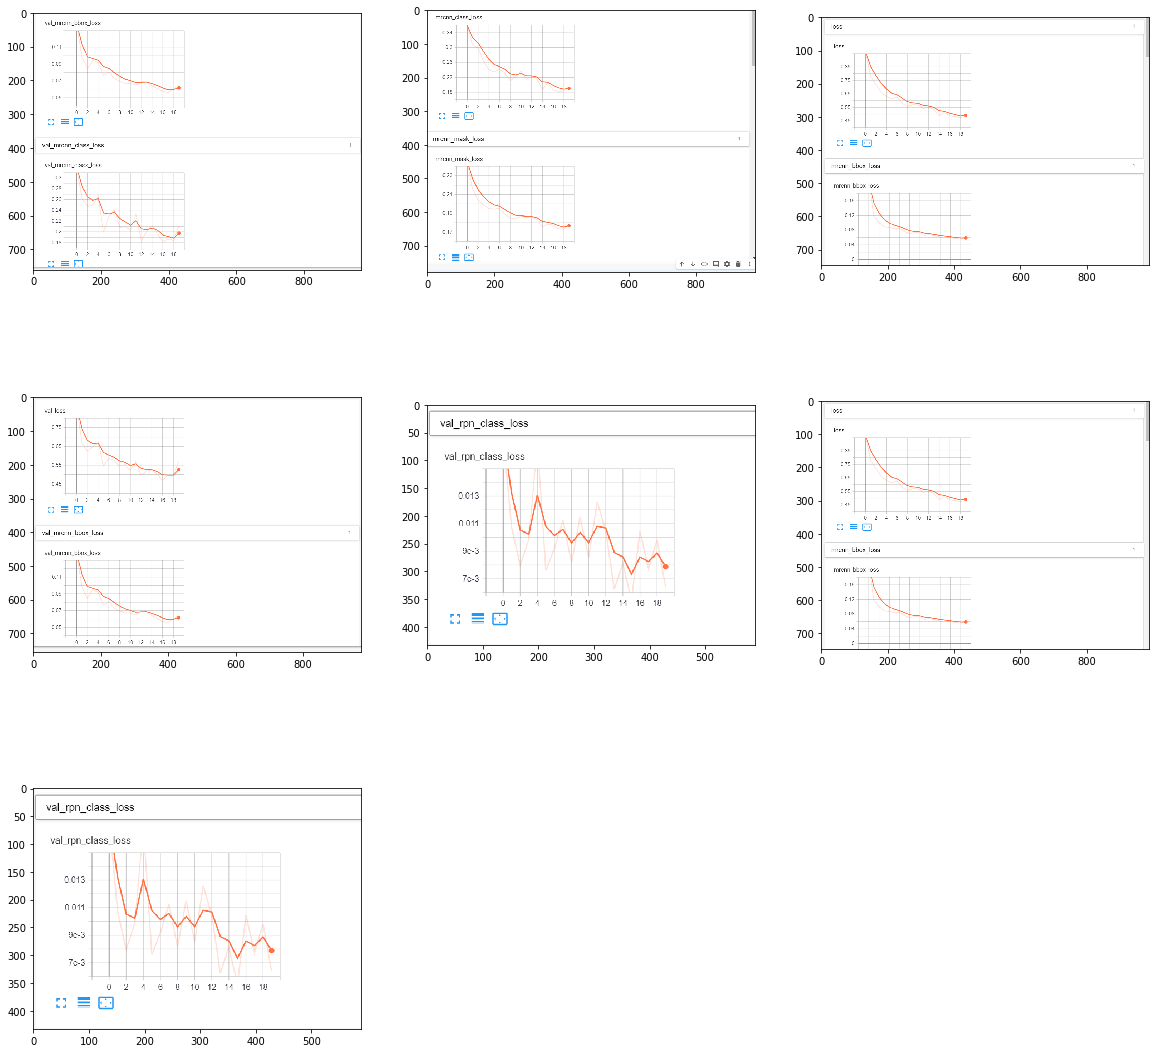

In [0]:
#showing tensorboard screenshot

fig = plt.figure(figsize= (20, 20))
cols = 3
rows = 3
_dir="/content/tens"
path=os.listdir(_dir)
for i in range(7):
    filePath = os.path.join(_dir,random.choice(path))
    ax1 = fig.add_subplot(rows, cols, i + 1)
    img = mpimg.imread(filePath)
    plt.imshow(img)
    
plt.show()

# DETECTION

In [0]:
#setting the prediction configuration

class InferenceConfig(DetectorConfig):
  
    '''
    Configuration for testing malaria detection on the malaria dataset.
    '''
  
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
inference_config = InferenceConfig()

# Recreate the model in inference mode

model = modellib.MaskRCNN(mode='inference', config=inference_config,model_dir=ROOT_DIR)

model_path="/content/drive/My Drive/mask2/malaria_cfg/mask_rcnn_malaria_0019.h5"

print("Loading weights from ", model_path)

model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/mask2/malaria_cfg/mask_rcnn_malaria_0019.h5


**Prediction on validation dataset**

In [0]:
'''function to show the actual image with bounding box and the predicted image with mask'''

def act_vs_pred(dataset,model,cfg):
  
  '''
  dataset:takes the dataset on which prediction is to be made
  model:trained model
  cfg:prediction configuration(here inference_config)
  return:actual image with bounding box and predicted image with mask
  '''
  
  img_id= random.choice(dataset.image_ids)
  img,img_meta,cls_id,bbox,mask=modellib.load_image_gt(dataset,cfg,img_id,use_mini_mask=False)
  
  #Actual image without mask
  
  visualize.display_instances(img,bbox,mask,cls_id,dataset.class_names,figsize=(8,8),title="Actual",show_mask=False)
  
  #predicted image with mask
  
  results=model.detect([img],verbose=1)
  r=results[0]
  visualize.display_instances(img,r['rois'],r['masks'],r['class_ids'],dataset.class_names,r['scores'],title="Prediction",figsize=(8,8))
                                                 

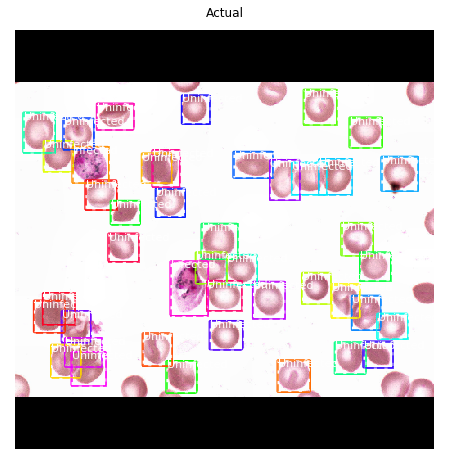

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


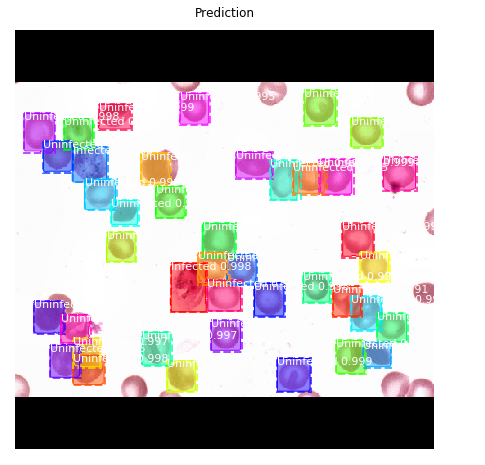

In [0]:
#prediction on val dataset

act_vs_pred(dataset_val,model,inference_config)

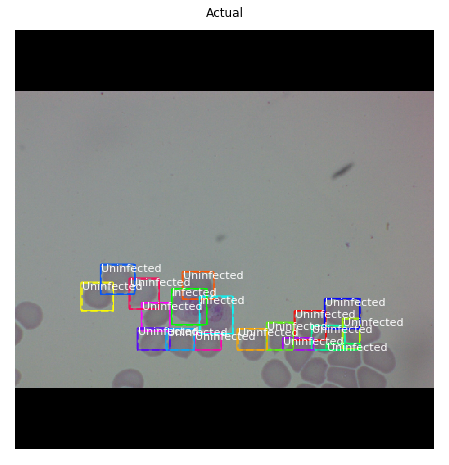

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  157.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   53.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


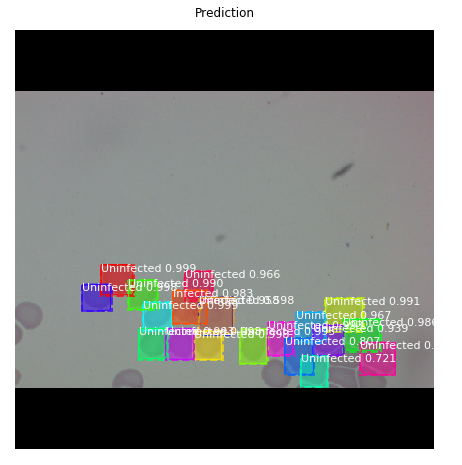

In [0]:
#prediction on test dataset

act_vs_pred(dataset_test,model,inference_config)

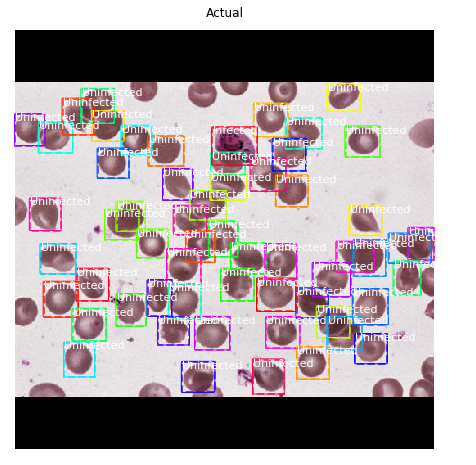

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


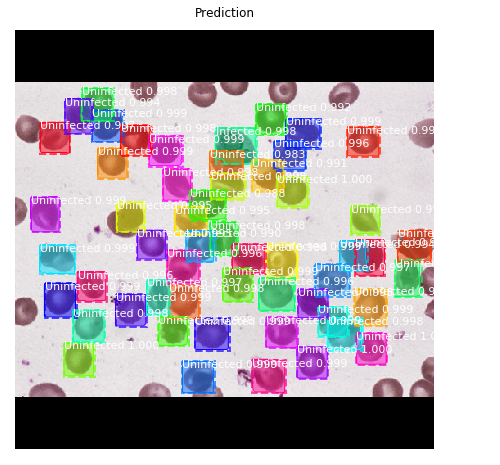

In [0]:
#prediction on train dataset

act_vs_pred(dataset_train,model,inference_config)

***Observation-***

most of the infected and uninfected cells are masked by the model.

# Let's see how model is working on minority data sample class

In [0]:
# name of image containing category other than 0

train_df.image[train_df.Category!=0][15:25]

309    0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png
310    0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png
344    7c66d2fd-68ee-4628-b860-9d7ad25b2a80.png
352    7c66d2fd-68ee-4628-b860-9d7ad25b2a80.png
437    84c88143-940d-4b62-bbd2-7acc4cadcb6b.png
438    84c88143-940d-4b62-bbd2-7acc4cadcb6b.png
461    c6d97845-8ad2-4ab7-b385-66613628df5b.png
470    bbf687b5-c6f9-4821-b2e5-a25df1acba47.png
509    67acd5bc-4658-4c6e-a9b9-cd8ea3a03418.png
605    065af549-320a-4862-b92a-8ef750d7b5fb.png
Name: image, dtype: object

Processing 1 images
image                    shape: (1200, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  134.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


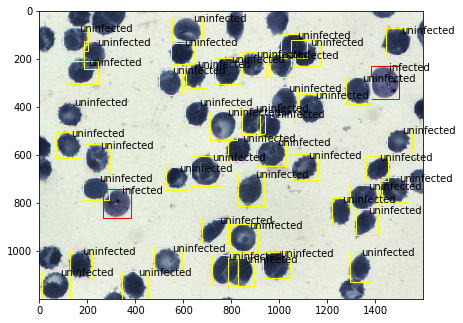

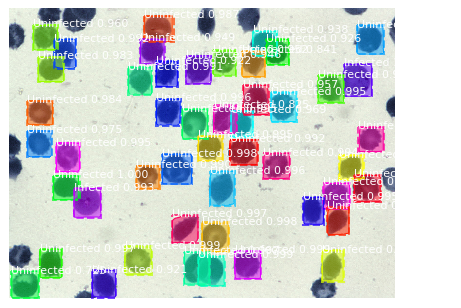

In [0]:
#https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image

fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
img = skimage.io.imread('/content/train_image/7c66d2fd-68ee-4628-b860-9d7ad25b2a80.png')
skimage.io.imshow(img)

# iterating over the image for different objects
for i,row in train_df[train_df.image == "7c66d2fd-68ee-4628-b860-9d7ad25b2a80.png"].iterrows():
    xmin = row.x_min
    xmax = row.x_max
    ymin = row.y_min
    ymax = row.y_max
    
    width = xmax - xmin
    height = ymax - ymin
    # assign different color to different classes of objects
    if row.Category == 0:
        edgecolor = 'yellow'
        ax.annotate('uninfected', xy=(xmax-40,ymin+20))
  
    else:
        edgecolor = 'red'
        ax.annotate('infected', xy=(xmax-40,ymin+20))
    
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

#predicted image
results = model.detect([img], verbose=1)
r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'],figsize=(7,7))
       

model is masking every infected cells

Processing 1 images
image                    shape: (1200, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


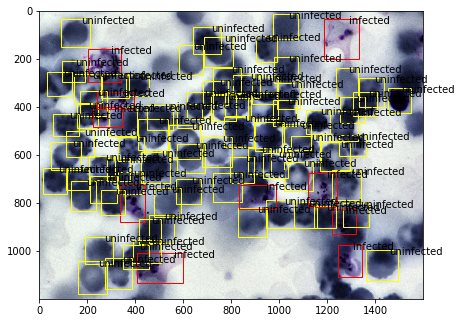

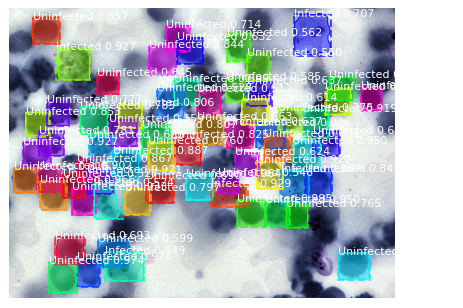

In [0]:
#https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image

fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
img = skimage.io.imread('/content/train_image/edcb4d77-a4d3-465d-9b59-eb3087766b1c.png')
skimage.io.imshow(img)

# iterating over the image for different objects
for _,row in train_df[train_df.image == "edcb4d77-a4d3-465d-9b59-eb3087766b1c.png"].iterrows():
    xmin = row.x_min
    xmax = row.x_max
    ymin = row.y_min
    ymax = row.y_max
    
    width = xmax - xmin
    height = ymax - ymin
    # assign different color to different classes of objects
    if row.Category == 0:
        edgecolor = 'yellow'
        ax.annotate('uninfected', xy=(xmax-40,ymin+20))
  
    else:
        edgecolor = 'red'
        ax.annotate('infected', xy=(xmax-40,ymin+20))
    
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

#predicted image
results = model.detect([img], verbose=1)
r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'],figsize=(7,7))
       

model is predicting some of the infected cells

In [0]:
test_df.image[test_df.Category!=0][:15]

63     41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg
120    64985a1e-16bb-4016-a01c-c21a5b86e572.jpg
121    64985a1e-16bb-4016-a01c-c21a5b86e572.jpg
122    64985a1e-16bb-4016-a01c-c21a5b86e572.jpg
194    c70894fa-50e8-4eed-a5a8-159a20153a49.jpg
195    c70894fa-50e8-4eed-a5a8-159a20153a49.jpg
196    c70894fa-50e8-4eed-a5a8-159a20153a49.jpg
248    abb72ce2-4193-4dd3-a34c-61c2ee22ccff.jpg
288    8db76867-671a-4488-a7b6-991e4dd2e05f.jpg
297    8db76867-671a-4488-a7b6-991e4dd2e05f.jpg
357    ebc4056e-d766-43cf-b6b4-5dac79d96e84.jpg
412    d9ecacb0-14c7-4862-930b-18bb51d5f392.jpg
461    96287315-87a1-4045-9e16-119e045bf12a.jpg
487    37df4ffb-f268-4557-94d6-bf68d005feae.jpg
488    37df4ffb-f268-4557-94d6-bf68d005feae.jpg
Name: image, dtype: object

Processing 1 images
image                    shape: (1383, 1944, 3)       min:   33.00000  max:  167.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   52.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1944.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


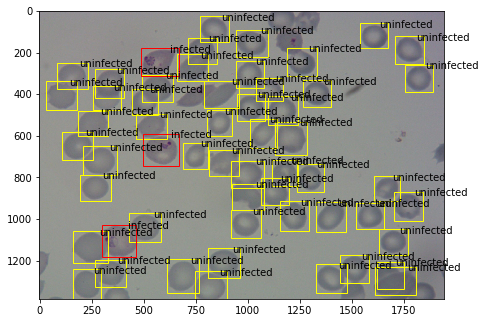

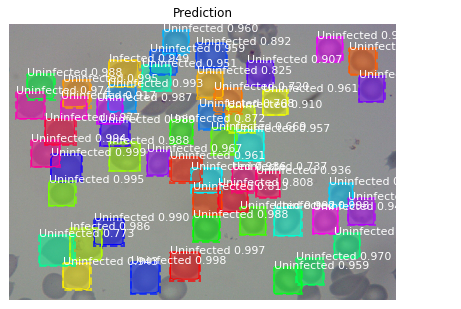

In [0]:
#https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image

fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('/content/test_image/64985a1e-16bb-4016-a01c-c21a5b86e572.jpg')
plt.imshow(image)


# iterating over the image for different objects
for _,row in test_df[test_df.image == "64985a1e-16bb-4016-a01c-c21a5b86e572.jpg"].iterrows():
    xmin = row.x_min
    xmax = row.x_max
    ymin = row.y_min
    ymax = row.y_max
    
    width = xmax - xmin
    height = ymax - ymin
    # assign different color to different classes of objects
    if row.Category == 0:
        edgecolor = 'yellow'
        ax.annotate('uninfected', xy=(xmax-40,ymin+20))
    
    else:
        edgecolor = 'red'
        ax.annotate('infected', xy=(xmax-40,ymin+20))
    
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)
    
    
    #predicted image with mask
  
result=model.detect([image],verbose=1)
r=result[0]
visualize.display_instances(image,r['rois'],r['masks'],r['class_ids'],dataset_val.class_names,r['scores'],title="Prediction",figsize=(7,7))
                               

above figure shows that every infected cells are masked by the model.

Processing 1 images
image                    shape: (1383, 1944, 3)       min:   26.00000  max:  171.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   53.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1944.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


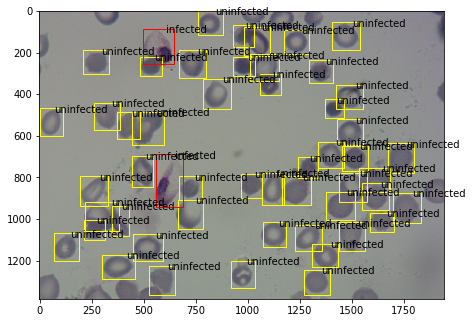

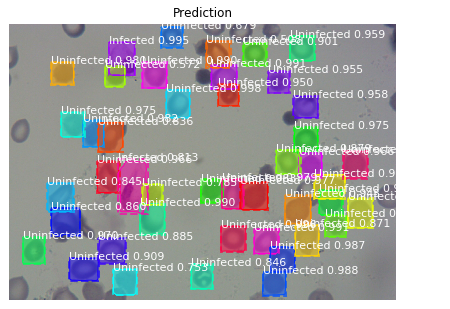

In [0]:
#https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image

fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('/content/test_image/bdfbad30-fa2f-4285-bf02-6064ab6d869c.jpg')
plt.imshow(image)


# iterating over the image for different objects
for _,row in test_df[test_df.image == "bdfbad30-fa2f-4285-bf02-6064ab6d869c.jpg"].iterrows():
    xmin = row.x_min
    
    xmax = row.x_max
    ymin = row.y_min
    ymax = row.y_max
    
    width = xmax - xmin
    height = ymax - ymin
    # assign different color to different classes of objects
    if row.Category == 0:
        edgecolor = 'yellow'
        ax.annotate('uninfected', xy=(xmax-40,ymin+20))
    
    else:
        edgecolor = 'red'
        ax.annotate('infected', xy=(xmax-40,ymin+20))
    
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)
    
    
    #predicted image with mask
  
result=model.detect([image],verbose=1)
r=result[0]
visualize.display_instances(image,r['rois'],r['masks'],r['class_ids'],dataset_val.class_names,r['scores'],title="Prediction",figsize=(7,7))
                               

Model predicts all the cell and also predicts the infected cells

# Final function

**Given an image,mask the cell**

Processing 1 images
image                    shape: (1383, 1944, 3)       min:   57.00000  max:  166.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   54.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1944.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


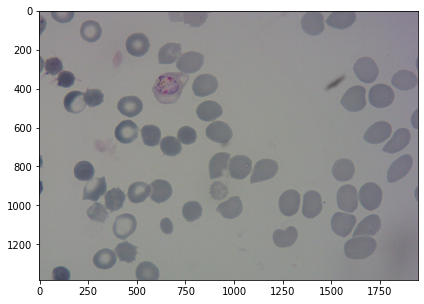

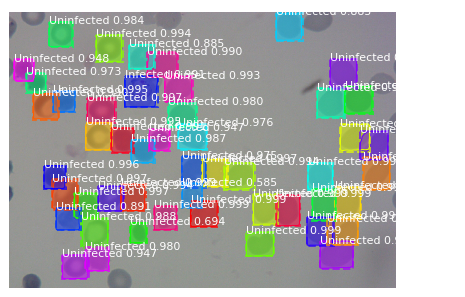

In [0]:
"""Final function which given an image predicts the mask"""

def final_funct(file):
  
    '''
    file:load the image
    return:image with mask
    '''
  
    #Actual image
    image = skimage.io.imread(file)
    plt.figure(figsize=(6,6))
    skimage.io.imshow(image)
    #predicted image
    results = model.detect([image], verbose=1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'],figsize=(7,7))

final_funct('/content/test_image/2.jpg')    

in the above figure ,model predicts most of the cells and also predicts minority class infected.

# Evaluate Model

In [0]:
# store the prediction on a given dataset
def prediction(dataset, model, cfg):
    result=[]
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        res.append((r['rois'],r['class_ids'],r['scores'],gt_bbox,gt_class_id))
        
    return result

In [0]:
res_train=prediction(dataset_train,model,inference_config)
res_val=prediction(dataset_val,model,inference_config)
res_test=prediction(dataset_test,model,inference_config)

Below code reference-https://github.com/MathGaron/mean_average_precision

In [0]:
"""Bounding box intersection over union calculation"""

def intersect_area(box_a, box_b):
    """
    Compute the area of intersection between two rectangular bounding box
    Bounding boxes use corner notation : [x1, y1, x2, y2]
    Args:
      box_a: (np.array) bounding boxes, Shape: [A,4].
      box_b: (np.array) bounding boxes, Shape: [B,4].
    Return:
      np.array intersection area, Shape: [A,B].
    """
    resized_A = box_a[:, np.newaxis, :]
    resized_B = box_b[np.newaxis, :, :]
    max_xy = np.minimum(resized_A[:, :, 2:], resized_B[:, :, 2:])
    min_xy = np.maximum(resized_A[:, :, :2], resized_B[:, :, :2])

    diff_xy = (max_xy - min_xy)
    inter = np.clip(diff_xy, a_min=0, a_max=np.max(diff_xy))
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """
    Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (np.array) Predicted bounding boxes,    Shape: [n_pred, 4]
        box_b: (np.array) Ground Truth bounding boxes, Shape: [n_gt, 4]
    Return:
        jaccard overlap: (np.array) Shape: [n_pred, n_gt]
    """
    inter = intersect_area(box_a, box_b)
    area_a = ((box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]))
    area_b = ((box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]))
    area_a = area_a[:, np.newaxis]
    area_b = area_b[np.newaxis, :]
    union = area_a + area_b - inter
    return inter / union

In [0]:
"""
    Simple accumulator class that keeps track of True positive, False positive and False negative
    to compute precision and recall of a certain class
"""


class APAccumulator:
    def __init__(self):
        self.TP, self.FP, self.FN = 0, 0, 0

    def inc_good_prediction(self, value=1):
        self.TP += value

    def inc_bad_prediction(self, value=1):
        self.FP += value

    def inc_not_predicted(self, value=1):
        self.FN += value

    @property
    def precision(self):
        total_predicted = self.TP + self.FP
        if total_predicted == 0:
            total_gt = self.TP + self.FN
            if total_gt == 0:
                return 1.
            else:
                return 0.
        return float(self.TP) / total_predicted

    @property
    def recall(self):
        total_gt = self.TP + self.FN
        if total_gt == 0:
            return 1.
        return float(self.TP) / total_gt

    def __str__(self):
        str = ""
        str += "True positives : {}\n".format(self.TP)
        str += "False positives : {}\n".format(self.FP)
        str += "False Negatives : {}\n".format(self.FN)
        str += "Precision : {}\n".format(self.precision)
        str += "Recall : {}\n".format(self.recall)
        return str

In [0]:
class DetectionMAP:
  
    def __init__(self,n_class,overlap_threshold,pr_samples=11):
        """
        Running computation of average precision of n_class in a bounding box + classification task
        :param n_class:             quantity of class
        :param pr_samples:          quantification of threshold for pr curve
        :param overlap_threshold:   minimum overlap threshold
        """
        self.n_class = n_class
        self.overlap_threshold = overlap_threshold
        self.pr_scale = np.linspace(0, 1, pr_samples)
        self.total_accumulators = []
        self.reset_accumulators()

    def reset_accumulators(self):
        """
        Reset the accumulators state
        total_accumulators : list of list of accumulators at each pr_scale for each class
        
        """
        self.total_accumulators = []
        for i in range(len(self.pr_scale)):
            class_accumulators = []
            for j in range(self.n_class+1):
                class_accumulators.append(APAccumulator())
            self.total_accumulators.append(class_accumulators)
        

    def evaluate(self, pred_bb, pred_classes, pred_conf, gt_bb, gt_classes):
      
        """
        Update the accumulator for the running mAP evaluation.
        For exemple, this can be called for each images
        :param pred_bb: (np.array)      Predicted Bounding Boxes [x1, y1, x2, y2] :     Shape [n_pred, 4]
        :param pred_classes: (np.array) Predicted Classes :                             Shape [n_pred]
        :param pred_conf: (np.array)    Predicted Confidences [0.-1.] :                 Shape [n_pred]
        :param gt_bb: (np.array)        Ground Truth Bounding Boxes [x1, y1, x2, y2] :  Shape [n_gt, 4]
        :param gt_classes: (np.array)   Ground Truth Classes :                          Shape [n_gt]
        :return:
        """

        if pred_bb.ndim == 1:
            pred_bb = np.repeat(pred_bb[:, np.newaxis], 4, axis=1)
        IoUmask = None
        if len(pred_bb) > 0:
            IoUmask = self.compute_IoU_mask(pred_bb, gt_bb, self.overlap_threshold)
        for accumulators, r in zip(self.total_accumulators, self.pr_scale):
            self.evaluate_(IoUmask, accumulators, pred_classes, pred_conf, gt_classes, r)

    @staticmethod
    def evaluate_(IoUmask, accumulators, pred_classes, pred_conf, gt_classes, confidence_threshold):
        pred_classes = pred_classes.astype(np.int)
        gt_classes = gt_classes.astype(np.int)
        
        for i, acc in enumerate(accumulators):
            gt_number = np.sum(gt_classes == i)
            pred_mask = np.logical_and(pred_classes == i, pred_conf >= confidence_threshold)
            pred_number = np.sum(pred_mask)
            if pred_number == 0:
                acc.inc_not_predicted(gt_number)
                continue

            IoU1 = IoUmask[pred_mask, :]
            mask = IoU1[:, gt_classes == i]

            tp = DetectionMAP.compute_true_positive(mask)
            fp = pred_number - tp
            fn = gt_number - tp
            acc.inc_good_prediction(tp)
            acc.inc_not_predicted(fn)
            acc.inc_bad_prediction(fp)

    @staticmethod
    def compute_IoU_mask(prediction, gt, overlap_threshold):
        IoU = jaccard(prediction, gt)
        # for each prediction select gt with the largest IoU and ignore the others
        for i in range(len(prediction)):
            maxj = IoU[i, :].argmax()
            IoU[i, :maxj] = 0
            IoU[i, (maxj + 1):] = 0
        # make a mask of all "matched" predictions vs gt
        return IoU >= overlap_threshold

    @staticmethod
    def compute_true_positive(mask):
        # sum all gt with prediction of its class
        return np.sum(mask.any(axis=0))

    def compute_ap(self, precisions, recalls):
      
        """
        Compute average precision of a particular classes (cls_idx)
        
        """
        previous_recall = 0
        average_precision = 0
        for precision, recall in zip(precisions[::-1], recalls[::-1]):
            average_precision += precision * (recall - previous_recall)
            previous_recall = recall
        return average_precision

    def compute_precision_recall_(self, class_index, interpolated=True):
      
        precisions = []
        recalls = []
        for acc in self.total_accumulators:
            precisions.append(acc[class_index].precision)
            recalls.append(acc[class_index].recall)

        if interpolated:
            interpolated_precision = []
            for precision in precisions:
                last_max = 0
                if interpolated_precision:
                    last_max = max(interpolated_precision)
                interpolated_precision.append(max(precision, last_max))
            precisions = interpolated_precision
        return precisions, recalls

    
    def result(self,interpolated=True):
        mAP=[]
        for i in range(1,n_class+1):
          pre,rec=self.compute_precision_recall_(i,interpolated)
          avg_pre=self.compute_ap(pre, rec)
          mAP.append(avg_pre)
          print("Class",i, "Average Precision: {:0.2f}".format(avg_pre))
        
        print("Mean average precision : {:0.2f}".format(sum(mAP)/len(mAP)))

In [0]:
#train results
n_class=2
print("Train Data: ")
print('***********')
thres=[0.5,0.65,0.75]
for i in thres:
  
  print("At Threshold:",i)
 
  mAP = DetectionMAP(n_class,i)
  for i, frame in enumerate(res_train):
      mAP.evaluate(*frame)

  mAP.result()
  print('\n')

Train Data: 
***********
At Threshold: 0.5
Class 1 Average Precision: 0.81
Class 2 Average Precision: 0.56
Mean average precision : 0.68


At Threshold: 0.65
Class 1 Average Precision: 0.80
Class 2 Average Precision: 0.55
Mean average precision : 0.68


At Threshold: 0.75
Class 1 Average Precision: 0.75
Class 2 Average Precision: 0.51
Mean average precision : 0.63




In [0]:
#valid results
n_class=2
print("Valid Data: ")
print('***********')
thres=[0.5,0.65,0.75]
for i in thres:
  
  print("At Threshold:",i)
 
  mAP = DetectionMAP(n_class,i)
  for i, frame in enumerate(res_val):
      mAP.evaluate(*frame)

  mAP.result()
  print('\n')

Valid Data: 
***********
At Threshold: 0.5
Class 1 Average Precision: 0.78
Class 2 Average Precision: 0.53
Mean average precision : 0.66


At Threshold: 0.65
Class 1 Average Precision: 0.77
Class 2 Average Precision: 0.53
Mean average precision : 0.65


At Threshold: 0.75
Class 1 Average Precision: 0.73
Class 2 Average Precision: 0.49
Mean average precision : 0.61




In [0]:
#Test results
n_class=2
print("Test Data: ")
print('***********')
thres=[0.5,0.65,0.75]
for i in thres:
  
  print("At Threshold:",i)
 
  mAP = DetectionMAP(n_class,i)
  for i, frame in enumerate(res_test):
      mAP.evaluate(*frame)

  mAP.result()
  print('\n')

Test Data: 
***********
At Threshold: 0.5
Class 1 Average Precision: 0.52
Class 2 Average Precision: 0.49
Mean average precision : 0.50


At Threshold: 0.65
Class 1 Average Precision: 0.48
Class 2 Average Precision: 0.47
Mean average precision : 0.47


At Threshold: 0.75
Class 1 Average Precision: 0.44
Class 2 Average Precision: 0.43
Mean average precision : 0.43




**Obsevation-**

1-Train and Validation mAP are not so good , it can be improved by training the model for more epochs.

2-Model is doing well at predicting majority class, uninfected(rbc+leukocyte).


**Steps used-**

1-Download and load the dataset.

2-Do the necessary eda to understand the dataset and convert it from containing 6 class to 2 class(infected +uninfected).

3-Clone the matterport mask rcnn github repository.

4-Prepare the dataset for training and validation in appropriate format.

5-Train the mask rcnn model on malaria dataset.

6-Detect on the test and other downloaded images.

7-Evaluate the performance of the model.


**Scope of improvement-**

1-Train the model for more epochs.

2-Use data augmentation technique which helps in detecting all the minority class cells.